### Import required packages

In [68]:
import pandas as pd
import os
import numpy as np
import opendatasets as od
import librosa as li
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

### Import and Explore Dataset
Currently using the [British Birdsong Dataset](https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download).

Download sound files from Kaggle.

(Get kaggle.json API token from [here](https://www.kaggle.com/settings) an place it in the notebooks folder).

In [2]:
dataset_url = 'https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download'
path_to_download = '../datasets'

od.download(dataset_url, data_dir=path_to_download)

100%|██████████| 633M/633M [00:27<00:00, 24.2MB/s] 


Load labels and audio files. Split them to target size and append them to a list.

In [56]:
csv_path = path_to_download + '/british-birdsong-dataset/birdsong_metadata.csv'
sound_files_path = path_to_download + '/british-birdsong-dataset/songs/songs/'

metadata = pd.read_csv(csv_path)[['file_id', 'english_cname']]

audio_data = []
labels = []
original_durations = []

SAMPLE_RATE = 44100
LENGTH_SECONDS = 15

# For every file listed in the CSV...
for j in metadata.itertuples():
  # Read file and get duration
  filename = sound_files_path + 'xc' + str(j[1]) + '.flac'
  y, sr = li.load(filename, sr=None)
  duration = li.get_duration(y=y, sr=sr)
  
  # Append duration to list
  original_durations.append(duration)
  
  total_samples = sr * LENGTH_SECONDS
  
  # If longer than target duration, split it in segments and append it to list
  if duration > LENGTH_SECONDS:
    for i in range(int(duration / LENGTH_SECONDS) + 1):
      sample = y[i * total_samples : (i + 1) * total_samples]
      
      # Right pad to shorter samples
      if len(sample) < total_samples:
        sample = np.pad(sample, (0, total_samples - len(sample)), 'constant')
      
      audio_data.append(sample)
      labels.append(j[2])
  
  # If shorter, right pad and append to list
  else:
    y = np.pad(y, (0, total_samples - len(y)), 'constant')
    audio_data.append(y)
    labels.append(j[2])
  
  # Wornig for files that not have the same sample rate
  if sr != SAMPLE_RATE:
    print(f'WARNING: Sample rate mismatch for xc{str(j[1])}.flac')
    
# Convert audio samples list to numpy array
audio_data = np.array(audio_data)

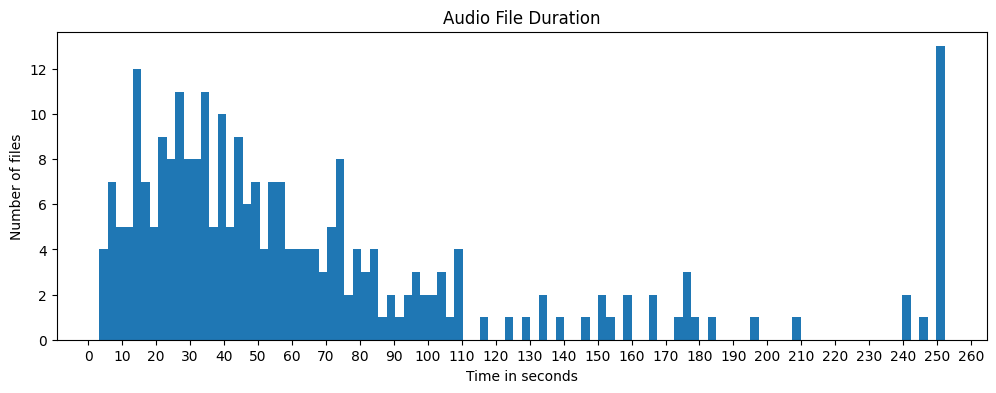

• Original file count: 264
• Total file count after splitting: 1308


In [57]:
# Plot histogram of original audio file durations
plt.subplots(figsize=(12,4))
plt.title('Audio File Duration')
plt.xlabel('Time in seconds')
plt.ylabel('Number of files')
plt.xticks(range(0, 300, 10))
plt.hist(original_durations, bins=100)
plt.show()

print(f'• Original file count: {len(original_durations)}')
print(f'• Total file count after splitting: {len(audio_data)}')

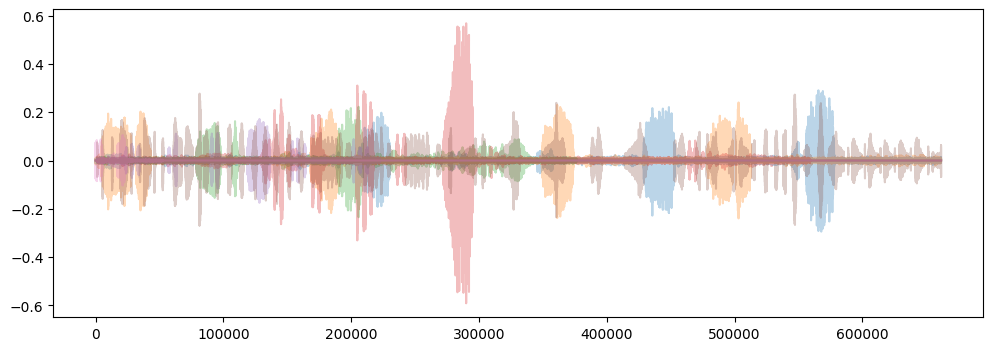

In [58]:
# Plot waveforms of several samples
plt.subplots(figsize=(12, 4))

for audio in audio_data[:7]:
  plt.plot(audio, alpha=0.3)
  
plt.show()

Convert audio time series in dataset to Mel spectrograms.

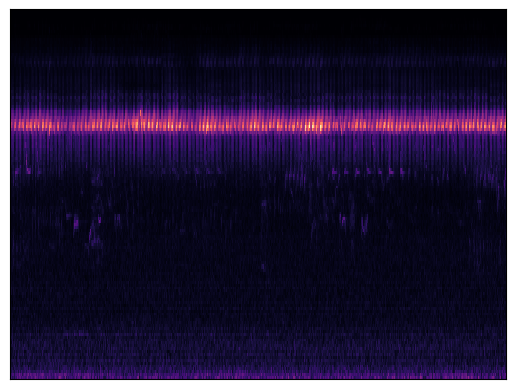

In [112]:
window_length = 2048
hop_length = 512

mel_spectrograms = []

for i in range(0, len(audio_data)):
  x = li.feature.melspectrogram(y=audio_data[i], sr=SAMPLE_RATE, n_fft=window_length, hop_length=hop_length, power=0.5, n_mels=128)
  mel_spectrograms.append(x)
  
np.array(mel_spectrograms)

li.display.specshow(mel_spectrograms[25])
plt.show()

Generate train-test-validation splits using sklearn.

In [113]:
SEED = 2505 
x_train, x_temp, y_train, y_temp = train_test_split(mel_spectrograms, labels, test_size=0.2, random_state=SEED)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=SEED)

print(f'Train samples: {len(x_train)} - Test samples: {len(x_test)} - Validation samples {len(x_val)}')

Train samples: 1046 - Test samples: 209 - Validation samples 53
